In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [21]:
import numpy as np
import pandas as pd

In [22]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

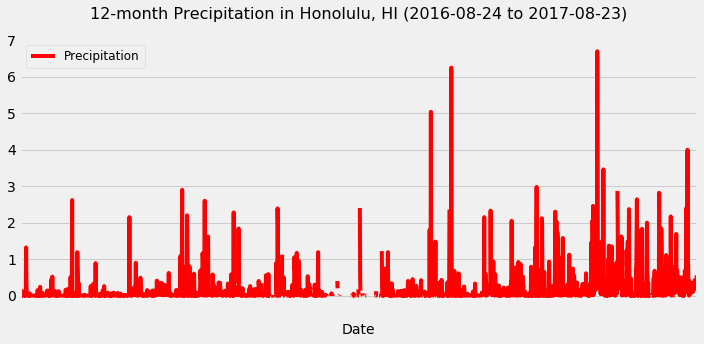

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date of the last data point in the database
last_measurement_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.datetime.strptime(last_measurement_date[0],'%Y-%m-%d').date() - dt.timedelta(weeks=52)

# Perform a query to retrieve the date and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).filter(Measurement.date <= last_measurement_date[0]).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_df = pd.DataFrame(prcp_scores, columns=['Date','Precipitation'])
prcp_scores_df.set_index('Date', inplace=True)

# Drop all rows that have NaN/blank values in the precipitation column 
prcp_scores_df['Precipitation'].dropna(inplace=True)

# Sort the dataframe by date
prcp_scores_df.sort_index(axis=0)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_scores_df.plot(figsize=(10,5), color='red')
ax.set_title(f'12-month Precipitation in Honolulu, HI ({date_year_ago} to {last_measurement_date[0]})', fontsize=16, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=15)
ax.legend(loc='best', fontsize=12)
plt.xticks([])
plt.tight_layout()
plt.savefig(f'images/Yearly_HI_Prcp_{date_year_ago}_{last_measurement_date[0]}.png', dpi=200)
plt.show()

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [48]:
# Query to show how many stations are available in this dataset

print(f"Number of Stations available in the dataset: {session.query(Station).count()}")

Number of Stations available in the dataset: 9


In [54]:
# Query to list the most active stations (i.e. stations that have the most rows)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station in active_stations:
    print(f"Station ID: {station[0]} | Number of Observations: {station[1]}")

Station ID: USC00519281 | Number of Observations: 2772
Station ID: USC00519397 | Number of Observations: 2724
Station ID: USC00513117 | Number of Observations: 2709
Station ID: USC00519523 | Number of Observations: 2669
Station ID: USC00516128 | Number of Observations: 2612
Station ID: USC00514830 | Number of Observations: 2202
Station ID: USC00511918 | Number of Observations: 1979
Station ID: USC00517948 | Number of Observations: 1372
Station ID: USC00518838 | Number of Observations: 511


In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()

print(f"Temperatures recorded at the most Active Station: {active_stations[0][0]}")
print(f"Lowest Temperature: {temps[0][0]}F")
print(f"Highest Temperature: {temps[0][1]}F")
print(f"Average Temperature: {round(temps[0][2],2)}F")

Temperatures recorded at the most Active Station: USC00519281
Lowest Temperature: 54.0F
Highest Temperature: 85.0F
Average Temperature: 71.66F


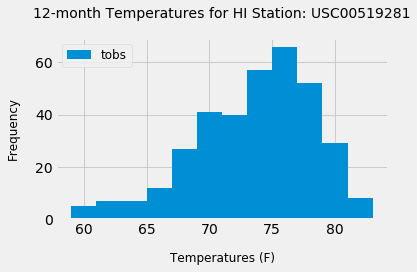

In [68]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations
temp_obs = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0]).filter(Measurement.date >= date_year_ago).filter(Measurement.date <= last_measurement_date[0]).all()

# Unpack tuple using list comprehensions
temps = [temp[0] for temp in temp_obs]

# Plot the results as a histogram
fig, ax = plt.subplots(tight_layout=True)
ax.hist(temps[::-1], bins=12)
ax.set_title(f'12-month Temperatures for HI Station: {active_stations[0][0]}', fontsize=14, pad=20)
ax.set_ylabel('Frequency', fontsize=12, labelpad=15)
ax.set_xlabel('Temperatures (F)', fontsize=12, labelpad=15)
ax.legend(['tobs'], loc='upper left', fontsize=12)
plt.savefig(f'images/Yearly_HI_Tobs_Station_{active_stations[0][0]}_{date_year_ago}_{last_measurement_date[0]}.png', dpi=200)
plt.show()

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [84]:
# Use previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip_dates = '2019-02-01 to 2019-02-15'
trip_start_date = '2017-02-01'
trip_end_date = '2017-02-15'

trip_temps = calc_temps(trip_start_date, trip_end_date)

tmin = trip_temps[0][0]
tavg = round(trip_temps[0][1],2)
tmax = trip_temps[0][2]

print(f"The min, avg, and max temperatures for my trip starting {trip_start_date} and ending {trip_end_date}:")
print(f"Minimum Temperature: {tmin}F")
print(f"Average Temperature: {tavg}F")
print(f"Maximum Temperature: {tmax}F")

The min, avg, and max temperatures for my trip starting 2017-02-01 and ending 2017-02-15:
Minimum Temperature: 59.0F
Average Temperature: 69.72F
Maximum Temperature: 80.0F


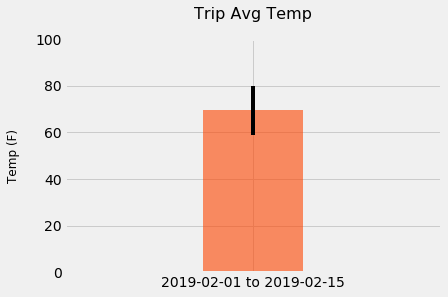

In [88]:
# Plot the results from the previous query as a bar chart. 
# Use "Trip Avg Temp" as the Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_min = tavg - tmin
error_max = tmax - tavg

error_bars = np.array([[error_min], [error_max]])

plt.bar(my_trip_dates, tavg, yerr=error_bars, color = 'orangered', alpha=.6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp', fontsize=16, pad=20)
plt.ylabel('Temp (F)', fontsize=12, labelpad=15)
plt.savefig(f'images/Trip_Avg_Temp_{my_trip_dates}.png', dpi=200)

In [92]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Design and execute query
sel = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])
rainfall_per_station = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= trip_start_date).filter(Measurement.date <= trip_end_date).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

# Convert Query Object to a Data Frame
rainfall_df= pd.DataFrame(np.array(rainfall_per_station))

# Rename columns in Data Frame before printing
rainfall_df = rainfall_df.rename(columns={0: "Station ID", 1: "Station Name", 2: "Total Rainfall", 3: "Latitude", 4: "Longitude", 5: "Elevation"})

rainfall_df

,Station ID,Station Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00513117,"KANEOHE 838.1, HI US",7.3100000000000005,21.4234,-157.8015,14.6
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",6.91,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",6.2299999999999995,21.45167,-157.84888999999998,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",5.24,21.5213,-157.8374,7.0
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.43,21.3331,-157.8025,152.4
5,USC00519397,"WAIKIKI 717.2, HI US",3.45,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
